<a href="https://colab.research.google.com/github/theaok/leonieAgency/blob/main/leonieAgency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#---------------------------SETUP----------------------------------
#get useful libraries
import io, time, os, sys, re #basics
import zipfile, json, datetime, string   #string for annotating points in scatter
import urllib.request
import numpy as np #basic math
from statistics import * #stats

import matplotlib.pyplot as plt #import pylab as plt #apparently discouraged now:
 #https://stackoverflow.com/questions/11469336/what-is-the-difference-between-pylab-and-pyplot
 #https://www.tutorialspoint.com/matplotlib/matplotlib_pylab_module.htm

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
#s4 = Styler(df4, uuid_len=0, cell_ids=False)

import urllib  #weird, guess need to have os and pandas imported for this to work  %TODO/LATER ditch it, its weird anyway, just use wget/curl

from google.colab import files

#import webbrowser

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

#many tricks how to extend notebook functionality
#https://coderzcolumn.com/tutorials/python/list-of-useful-magic-commands-in-jupyter-notebook-lab
#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#MAGICS and THEMES/STYLES: important! does affect not just shading/colors, but also fonts, spacing, etc
#(even if you only select default (v not selecting anything) [but does seem to work better if you do make explicit sleections])

###magics: https://ipython.readthedocs.io/en/stable/interactive/magics.html
#most essential setup for vis: it does affect vis! careful!! stick with inline, maybe notebook; others mostly for non-notebook, eg spyder environ
#https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html recomends *inline*!
#show current one:
#%matplotlib
#%matplotlib --list
#interactive plots:
#%matplotlib notebook
#static images of your plot:
%matplotlib inline
#may play with this one and other magics (btw default is probably agg)
#%matplotlib nbagg
##https://www.marktechpost.com/2023/10/20/6-magic-commands-for-jupyter-notebooks-in-python-data-science/
#%%latex
#%ai
#%run
#%writefile
#%history -n

###themes/styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
#https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
#https://matplotlib.org/stable/tutorials/introductory/customizing.html
#here more about art and style than under the hood functionality as with magics, explore and experiment
#many may find 'default' or seaborn ones more pleasing; my fav 'classic' is back from 90s ;)
#plt.style.available #list available styles :) may install more
#plt.style.use('default') # more delicate subtle than classic
plt.style.use('classic')  #  'seaborn-whitegrid' 'seaborn-white' 'seaborn-poster'
# btw: magics v theme/style sequence matters, eg if i specify classic style before inline magic, i wouldnt get grey bounding box im getting

#sometimes have to install library which you get from https://pypi.org/
#!pip install geopandas

In [2]:
wvs0 = pd.read_stata('http://theaok.github.io/junk/wvs.tar.bz2', convert_categoricals=False)
wvs = wvs0[wvs0['S002VS']==7]
wvs.shape

(94278, 192)

In [3]:
#collapse data by cc claculating means on numeric variables
numeric_cols = wvs.select_dtypes(include=np.number).columns
numeric_cols
wvs_collapsed = wvs.groupby('cc')[numeric_cols].mean()
wvs_collapsed.shape


wvs_collapsed.columns.tolist()

Index(['S002VS', 'c', 'S004', 'S006', 'S007', 'S010', 'S013', 'S013B', 'S016',
       'S016B',
       ...
       'cat', 'pro', 'incIne', 'fair', 'famUns', 'hap', 'monSafHumIde',
       'aut_ind', 'myself', 'dec_mys'],
      dtype='object', length=190)

(64, 190)

['S002VS',
 'c',
 'S004',
 'S006',
 'S007',
 'S010',
 'S013',
 'S013B',
 'S016',
 'S016B',
 'S017',
 'S018',
 'yr',
 'S021',
 'S022',
 'S023',
 'S024',
 'S025',
 'A006',
 'A008',
 'health',
 'A058',
 'A059',
 'A060',
 'A061',
 'bel_rel',
 'A066',
 'A074',
 'A091',
 'A098',
 'trust',
 'A168',
 'fair10',
 'ls',
 'freedom',
 'impIncConCon',
 'nat_mas',
 'satFin',
 'D001',
 'E001',
 'E002',
 'E003',
 'E004',
 'E005',
 'E006',
 'mat_bad',
 'E015',
 'E018',
 'E019',
 'E023',
 'E032',
 'lr',
 'E035',
 'priPub',
 'govRes',
 'comBad',
 'worSuc',
 'weaAll',
 'E063',
 'E069_01',
 'E069_02',
 'E069_03',
 'E069_04',
 'E069_05',
 'E069_06',
 'E069_07',
 'E069_08',
 'E069_09',
 'E069_10',
 'E069_11',
 'E069_12',
 'E069_13',
 'E069_14',
 'E069_15',
 'E069_17',
 'E069_18',
 'E069_18A',
 'E069_19',
 'E069_20',
 'E069_21',
 'E069_22',
 'E069_23',
 'E069_24',
 'E069_25',
 'E069_26',
 'E069_27',
 'E069_28',
 'E069_29',
 'E069_30',
 'E069_31',
 'E069_32',
 'E069_33',
 'E069_34',
 'E069_35',
 'E069_38',
 'E0

In [4]:
wvs_collapsed.yr.value_counts()

,count
yr,
2018.0,26
2020.0,14
2022.0,7
2017.0,6
2019.0,6
2021.0,5


In [8]:
selected_columns = ['incIne', 'govRes', 'comBad', 'worSuc', 'freedom', 'trust']
wvs_selected = wvs_collapsed[selected_columns].round(2)
wvs_selected

,incIne,govRes,comBad,worSuc,freedom,trust
cc,,,,,,
AND,4.86,6.53,3.13,4.58,7.52,0.26
ARG,5.43,5.98,4.74,4.69,7.77,0.21
ARM,2.05,6.82,2.96,4.08,7.77,0.08
AUS,5.00,5.66,3.58,4.24,7.67,0.54
BGD,7.04,6.74,3.44,3.35,7.27,0.13
...,...,...,...,...,...,...
URY,4.80,5.58,4.38,5.29,8.29,0.15
USA,6.07,5.43,3.23,3.77,7.71,0.40
VEN,3.84,4.86,5.15,5.00,7.73,0.14


countries that are low on govRes are failed states or authritarian states like IRQ, NIC, VEN, but also individualistic/capitalistic like USA, HKG

trust is low in lat am like BRA, COL, MEX; and high surprisingly in CHN, and classic ones like NLD, CAN, GBR

In [11]:
wvs_selected.style.background_gradient(cmap='RdYlGn').format(precision=2)

,incIne,govRes,comBad,worSuc,freedom,trust
cc,,,,,,
AND,4.86,6.53,3.13,4.58,7.52,0.26
ARG,5.43,5.98,4.74,4.69,7.77,0.21
ARM,2.05,6.82,2.96,4.08,7.77,0.08
AUS,5.00,5.66,3.58,4.24,7.67,0.54
BGD,7.04,6.74,3.44,3.35,7.27,0.13
BOL,4.57,5.26,5.05,4.38,7.48,0.09
BRA,5.92,7.45,3.77,4.64,7.56,0.07
CAN,5.46,5.47,4.18,4.91,7.43,0.50
CHL,7.06,6.57,4.62,4.69,7.49,0.14


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 12.6 MB/s eta 0:00:00


<Figure size 960x800 with 0 Axes>

<Axes: xlabel='govRes', ylabel='cc'>

Text(0.5, 1.0, 'Government Regulation (govRes) by Country and Continent')

Text(0.5, 0, 'Government Regulation Score')

Text(0, 0.5, 'Country Code')

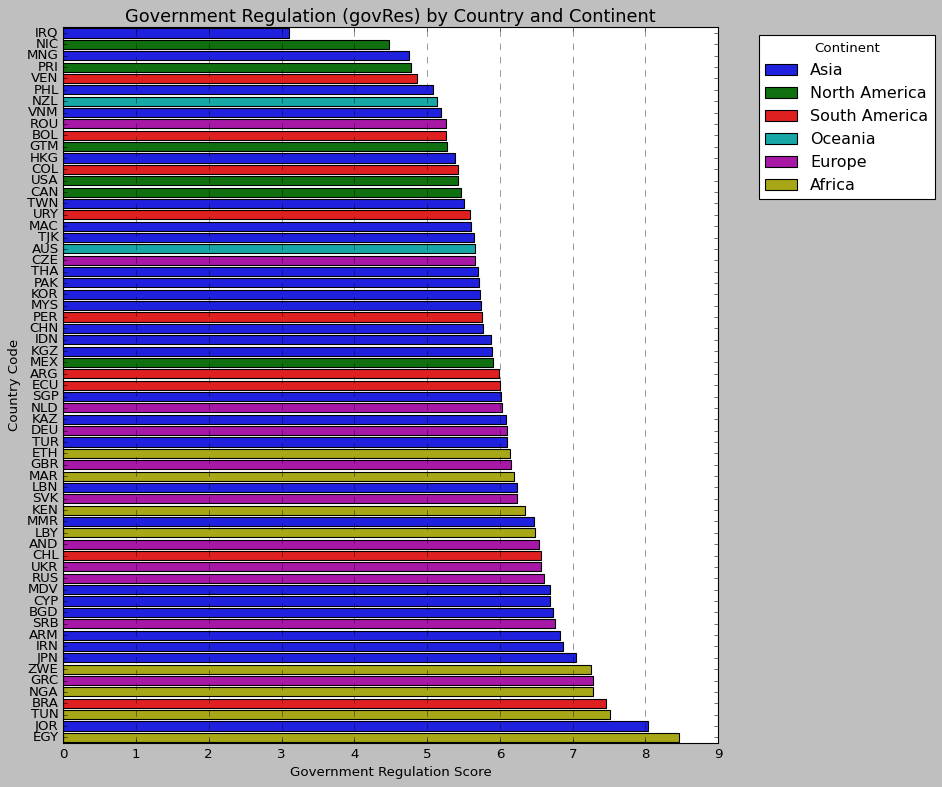

In [6]:
#make a horizontal bar chart of govRes by cc ordering on govRes and color code bars with different colors for different continents for countries defined with 3 letter codes in cc variable
try:
    import pycountry_convert as pc
except ImportError:
    !pip install pycountry-convert
    import pycountry_convert as pc

def country_code_to_continent(country_code):
    try:
        cn_alpha2 = pc.country_alpha3_to_country_alpha2(country_code)
        cn_continent = pc.country_alpha2_to_continent_code(cn_alpha2)
        return pc.convert_continent_code_to_continent_name(cn_continent)
    except KeyError:
        return np.nan

# Create a new 'continent' column based on the 'cc' index
wvs_collapsed_plot = wvs_collapsed.copy()
wvs_collapsed_plot['continent'] = wvs_collapsed_plot.index.map(country_code_to_continent)

# Filter out countries where continent could not be determined
wvs_collapsed_plot = wvs_collapsed_plot.dropna(subset=['continent'])

# Sort by 'govRes' for ordering the bars
wvs_collapsed_plot = wvs_collapsed_plot.sort_values('govRes', ascending=True)

# Create the horizontal bar chart
plt.figure(figsize=(12, 10))
sns.barplot(
    x='govRes',
    y=wvs_collapsed_plot.index,
    hue='continent',
    data=wvs_collapsed_plot,
    dodge=False
)

plt.title('Government Regulation (govRes) by Country and Continent', fontsize=16)
plt.xlabel('Government Regulation Score', fontsize=12)
plt.ylabel('Country Code', fontsize=12)
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()